In [5]:
import numpy as np
import pandas as pd
import string
import random
import keras
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from keras.layers import Input,concatenate
from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from keras.models import Model
from transformers import DistilBertTokenizer,TFDistilBertModel, TFBertModel,TFDistilBertForSequenceClassification,DistilBertModel,BertTokenizer, BertModel
from transformers import AdamWeightDecay
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import language_tool_python    
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertForSequenceClassification, AdamWeightDecay
import tensorflow as tf
import time
import re
from textattack.augmentation import WordNetAugmenter
from sklearn.metrics import classification_report, confusion_matrix


[nltk_data] Downloading package punkt to C:\Users\Sharmi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sharmi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sharmi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df = pd.read_excel('training.xlsx')
df

,Employment,Sanitation experience,Expected
0,Student,I've never had any serious issues in using wor...,1
1,Student,Bad,0
2,Student,Satisfied about the cleanliness of the study ...,1
3,Student,It should have more rest rooms not like 2 or 3...,0
4,Student,Set up a hygiene station with personalised cle...,0
...,...,...,...
355,Student,Maintenance should be neat,0
356,Student,I hate the idea of western toilets. And moreov...,0
357,Student,Restrooms are clean ans safe,1
358,Student,It is good clean,1


In [7]:
test = pd.read_excel("test.xlsx")
test

,Employment,Sanitation experience,Expected
0,Student,Good,NaN
1,Student,Accessibility and cleanliness are consistently...,NaN
2,Student,Restroom in our college is very clean.Then mai...,NaN
3,Student,Good,NaN
4,Student,"The restroom is very far from my class, it is ...",NaN
...,...,...,...
68,Student,It's good,NaN
69,Student,I feel there should be more western toilets,NaN
70,Student,Very nice,NaN
71,Student,It's good,NaN


In [8]:
def clean_text(text):
    # lower text 
    text = text.lower()
    #removing stop words
    text = ' '.join([e_words for e_words in text.split(' ') if e_words not in stopwords.words('english')])
    #removing puncuation
    text=re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n' , '', text)
    #remove words containing numbers
    #tokenizer
    text = nltk.word_tokenize(text)
    #lemmatizer
    wn = nltk.WordNetLemmatizer()
    text = [wn.lemmatize(word) for word in text]
    text = " ".join(text)
    return text

In [9]:
def textattack_data_augment(data, target, texattack_augmenter):
  aug_data = []
  aug_label = []
  for text, label in zip(data, target):
    if random.randint(0,2) != 1:
      aug_data.append(text)
      aug_label.append(label)
      continue
    aug_list = texattack_augmenter.augment(text)
    aug_data.append(text)
    aug_label.append(label)
    aug_data.extend(aug_list)
    aug_label.extend([label]*len(aug_list))
  return aug_data, aug_label

In [10]:
word_aug = WordNetAugmenter(pct_words_to_swap=0.2, transformations_per_example=3)
aug_data, aug_lable = textattack_data_augment(df["Sanitation experience"].apply(clean_text), df["Expected"], word_aug)
print(aug_data, aug_lable)
print(len(aug_data))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Sharmi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


['never serious issue using work study place restroom', 'never serious issue using work report place restroom', 'never serious publication using work study place restroom', 'never serious upshot using work study place restroom', 'bad', 'satisfied cleanliness study place', 'rest room like 2 3 tissue sanitary napkin atleast clean odour free', 'set hygiene station personalised cleaning product supply', 'set hygiene station personalized cleaning product supply', 'satisfied due uncleanliness odour', 'fill due uncleanliness odour', 'satisfied due uncleanliness aroma', 'satisfied due uncleanliness smell', 'feeling safeand satisfied cleanliness others', 'restroom good', 'worst', 'bad', 'forged', 'regretful', 'travel time faced lot struggle public toilet also much clean safe due reasonin recent time restricted using public toilet possible', 'jaunt time faced sight struggle public lav also much blank safe due reasonin recent time restricted using public toilet possible', 'journey time faced wad 

In [11]:
max_fatures = 1000
'''
using tokenizer from keras to convert text 
to their numeric form for embedding
'''
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(aug_data)
X = tokenizer.texts_to_sequences(aug_data)
X = pad_sequences(X)
X.shape


(723, 181)

In [12]:
#lstm implementation
embed_dim = 128
lstm_out = 196
lstm_model = Sequential()
lstm_model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
lstm_model.add(SpatialDropout1D(0.5))
lstm_model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.5))
lstm_model.add(Dense(2,activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\Users\Sharmi\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
Y = pd.get_dummies(aug_lable).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 28)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(506, 181) (506, 2)
(217, 181) (217, 2)


In [14]:
#train lstm
batch_size = 6
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
start_time = time.time()
lstm_history =lstm_model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 2, validation_data = (X_test,Y_test))
lstm_time = time.time() - start_time
print(lstm_model.summary())
print(lstm_time)

Epoch 1/20
85/85 - 10s - 117ms/step - accuracy: 0.6423 - loss: 0.6363 - val_accuracy: 0.6221 - val_loss: 0.6570
Epoch 2/20
85/85 - 7s - 87ms/step - accuracy: 0.7292 - loss: 0.5648 - val_accuracy: 0.7051 - val_loss: 0.5343
Epoch 3/20
85/85 - 8s - 91ms/step - accuracy: 0.8142 - loss: 0.4280 - val_accuracy: 0.7926 - val_loss: 0.4296
Epoch 4/20
85/85 - 8s - 97ms/step - accuracy: 0.8439 - loss: 0.3590 - val_accuracy: 0.8065 - val_loss: 0.3906
Epoch 5/20
85/85 - 9s - 107ms/step - accuracy: 0.9032 - loss: 0.2727 - val_accuracy: 0.8341 - val_loss: 0.3651
Epoch 6/20
85/85 - 9s - 102ms/step - accuracy: 0.9130 - loss: 0.2567 - val_accuracy: 0.8571 - val_loss: 0.3171
Epoch 7/20
85/85 - 9s - 105ms/step - accuracy: 0.9249 - loss: 0.2130 - val_accuracy: 0.8157 - val_loss: 0.3420
Epoch 8/20
85/85 - 9s - 107ms/step - accuracy: 0.9368 - loss: 0.1737 - val_accuracy: 0.8525 - val_loss: 0.3433
Epoch 9/20
85/85 - 9s - 101ms/step - accuracy: 0.9526 - loss: 0.1572 - val_accuracy: 0.8525 - val_loss: 0.3096
Epo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ embedding (Embedding)         │ (None, 181, 128)      │      128,000 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ spatial_dropout1d             │ (None, 181, 128)      │            0 │
│ (SpatialDropout1D)            │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm (LSTM)                   │ (None, 196)           │      254,800 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 2)             │          394 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 1,149,584 (4.39 MB)

 Trainable params: 383,194 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 766,390 (2.92 MB)

None
169.5347409248352


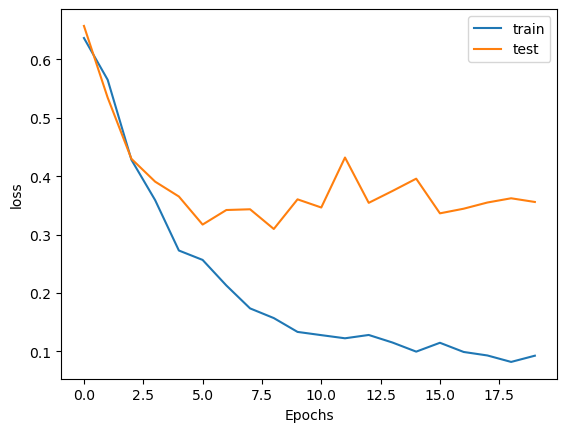

In [15]:
plt.plot(lstm_history.history['loss'],label='train')
plt.plot(lstm_history.history['val_loss'],label='test')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [17]:
score = lstm_model.evaluate(X_test, Y_test, verbose=2)

7/7 - 1s - 83ms/step - accuracy: 0.8848 - loss: 0.3558


In [18]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.35579583048820496
Test Accuracy: 0.8847926259040833


In [19]:
temp  = lstm_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


In [20]:
lstm_model.fit(X, Y, epochs = 5, batch_size=batch_size, verbose = 2)


Epoch 1/5
121/121 - 19s - 157ms/step - accuracy: 0.9336 - loss: 0.1694
Epoch 2/5
121/121 - 20s - 162ms/step - accuracy: 0.9502 - loss: 0.1376
Epoch 3/5
121/121 - 19s - 158ms/step - accuracy: 0.9530 - loss: 0.1295
Epoch 4/5
121/121 - 16s - 136ms/step - accuracy: 0.9627 - loss: 0.1056
Epoch 5/5
121/121 - 15s - 128ms/step - accuracy: 0.9654 - loss: 0.1114


In [21]:
# Predicting on the test set for LSTM
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = y_pred_lstm.argmax(axis=1)  # Convert probabilities to class labels
y_true_lstm = Y_test.argmax(axis=1)  # Convert one-hot encoded labels to class labels
# Generating classification reports
print("LSTM Model Performance:")
print(classification_report(y_true_lstm, y_pred_lstm))


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step
LSTM Model Performance:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       111
           1       0.97      0.98      0.98       106

    accuracy                           0.98       217
   macro avg       0.98      0.98      0.98       217
weighted avg       0.98      0.98      0.98       217



In [22]:
#splitting data for DistilBERT and BERT
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["Sanitation experience"], df["Expected"], test_size=0.3, random_state=42
)

In [23]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [27]:
# ---- DistilBERT Model Implementation ----
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = distilbert_tokenizer(list(train_texts
                                           ), truncation=True, padding=True, max_length=100, return_tensors="tf")
val_encodings = distilbert_tokenizer(list(val_texts), truncation=True, padding=True, max_length=100, return_tensors="tf")

train_inputs = {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}
val_inputs = {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']}

# Load DistilBERT model for binary classification
distilbert_model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Use AdamWeightDecay from transformers to avoid optimizer-related errors
optimizer = AdamWeightDecay(learning_rate=2e-5)

distilbert_model.compile(optimizer=optimizer,
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=['accuracy'])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [28]:
#Train distilBERT
start_time = time.time()
distilbert_history = distilbert_model.fit(train_inputs, train_labels, epochs=20, validation_data=(val_inputs, val_labels), batch_size=16)
distilbert_time = time.time() - start_time
print(distilbert_time)

Epoch 1/20
16/16 [==============================] - 55s 2s/step - loss: 0.6612 - accuracy: 0.6032 - val_loss: 0.5851 - val_accuracy: 0.8148
Epoch 2/20
16/16 [==============================] - 32s 2s/step - loss: 0.4835 - accuracy: 0.8532 - val_loss: 0.3480 - val_accuracy: 0.9259
Epoch 3/20
16/16 [==============================] - 41s 3s/step - loss: 0.2325 - accuracy: 0.9524 - val_loss: 0.2078 - val_accuracy: 0.9167
Epoch 4/20
16/16 [==============================] - 31s 2s/step - loss: 0.0931 - accuracy: 0.9722 - val_loss: 0.2278 - val_accuracy: 0.9074
Epoch 5/20
16/16 [==============================] - 47s 3s/step - loss: 0.0352 - accuracy: 1.0000 - val_loss: 0.2192 - val_accuracy: 0.9444
Epoch 6/20
16/16 [==============================] - 49s 3s/step - loss: 0.0195 - accuracy: 1.0000 - val_loss: 0.2181 - val_accuracy: 0.9444
Epoch 7/20
16/16 [==============================] - 58s 4s/step - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.2200 - val_accuracy: 0.9352
Epoch 8/20
16/16 [==

In [29]:
print(distilbert_model.summary())

Model: "tf_distil_bert_for_sequence_classification_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
 dropout_59 (Dropout)        multiple                  0         
                                                                 
Total params: 66955010 (255.41 MB)
Trainable params: 66955010 (255.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


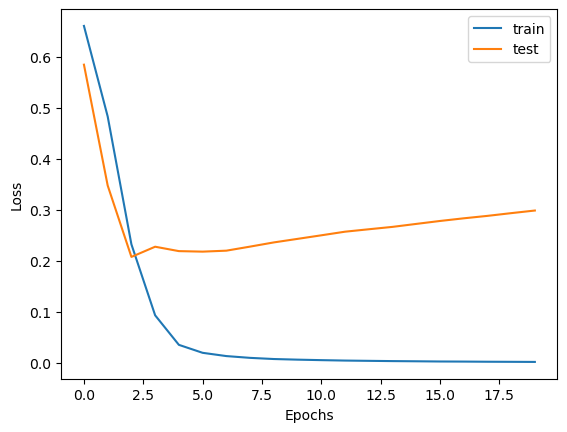

In [30]:
plt.plot(distilbert_history.history['loss'],label='train')
plt.plot(distilbert_history.history.get('val_loss',[]), label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [31]:
 score = distilbert_model.evaluate(val_inputs,val_labels, verbose=2)

4/4 - 7s - loss: 0.2988 - accuracy: 0.9167 - 7s/epoch - 2s/step


In [32]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.29882997274398804
Test Accuracy: 0.9166666865348816


In [33]:
temp  = distilbert_model.predict(val_inputs)

4/4 [==============================] - 17s 2s/step


In [34]:
distilbert_model.fit(val_inputs, val_labels, epochs =5, batch_size=5, verbose = 2)

Epoch 1/5
22/22 - 63s - loss: 0.8386 - accuracy: 0.8333 - 63s/epoch - 3s/step
Epoch 2/5
22/22 - 33s - loss: 0.1820 - accuracy: 0.9444 - 33s/epoch - 1s/step
Epoch 3/5
22/22 - 35s - loss: 0.0749 - accuracy: 0.9722 - 35s/epoch - 2s/step
Epoch 4/5
22/22 - 31s - loss: 0.0194 - accuracy: 1.0000 - 31s/epoch - 1s/step
Epoch 5/5
22/22 - 35s - loss: 0.0138 - accuracy: 1.0000 - 35s/epoch - 2s/step


In [35]:
# Predicting on the test set for DistilBERT
y_pred_distilbert = distilbert_model.predict(val_inputs)
y_pred_distilbert = y_pred_distilbert.logits.argmax(axis=1)
y_true_distilbert = val_labels  # Already in correct format
# Generating classification reports
print("DistilBERT Model Performance:")
print(classification_report(y_true_distilbert, y_pred_distilbert))

4/4 [==============================] - 7s 1s/step
DistilBERT Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        50

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



In [36]:
# ---- BERT Model Implementation ----
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = bert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=100, return_tensors="tf")
val_encodings = bert_tokenizer(list(val_texts), truncation=True, padding=True, max_length=100, return_tensors="tf")

train_inputs = {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}
val_inputs = {'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']}

# Load BERT model for binary classification
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
# Use AdamWeightDecay optimizer
optimizer = AdamWeightDecay(learning_rate=2e-5)

bert_model.compile(optimizer=optimizer,
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

# Train BERT Model
start_time = time.time()
bert_history = bert_model.fit(train_inputs, train_labels, epochs=20, validation_data=(val_inputs, val_labels), batch_size=16)
bert_time = time.time() - start_time


Epoch 1/20
16/16 [==============================] - 242s 9s/step - loss: 0.6575 - accuracy: 0.6349 - val_loss: 0.5768 - val_accuracy: 0.7685
Epoch 2/20
16/16 [==============================] - 81s 5s/step - loss: 0.4734 - accuracy: 0.8611 - val_loss: 0.3845 - val_accuracy: 0.8889
Epoch 3/20
16/16 [==============================] - 73s 5s/step - loss: 0.2245 - accuracy: 0.9484 - val_loss: 0.2491 - val_accuracy: 0.8889
Epoch 4/20
16/16 [==============================] - 97s 6s/step - loss: 0.0725 - accuracy: 0.9881 - val_loss: 0.2232 - val_accuracy: 0.9259
Epoch 5/20
16/16 [==============================] - 84s 5s/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.2772 - val_accuracy: 0.8981
Epoch 6/20
16/16 [==============================] - 59s 4s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.3538 - val_accuracy: 0.9167
Epoch 7/20
16/16 [==============================] - 69s 4s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.3962 - val_accuracy: 0.9167
Epoch 8/20
16/16 [=

In [70]:
print(bert_time)

1977.2213060855865


In [38]:
print(bert_model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_97 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109483778 (417.65 MB)
Trainable params: 109483778 (417.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


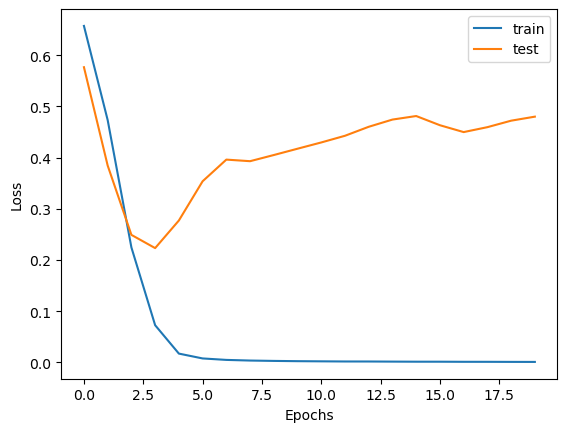

In [39]:
plt.plot(bert_history.history['loss'],label='train')
plt.plot(bert_history.history.get('val_loss',[]), label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [40]:
 score = bert_model.evaluate(val_inputs,val_labels, verbose=2)

4/4 - 18s - loss: 0.4801 - accuracy: 0.8981 - 18s/epoch - 5s/step


In [41]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.48013269901275635
Test Accuracy: 0.8981481194496155


In [42]:
temp  = bert_model.predict(val_inputs)

4/4 [==============================] - 42s 4s/step


In [43]:
bert_model.fit(val_inputs, val_labels, epochs =5, batch_size=5, verbose = 2)

Epoch 1/5
22/22 - 133s - loss: 0.5479 - accuracy: 0.8611 - 133s/epoch - 6s/step
Epoch 2/5
22/22 - 77s - loss: 0.2128 - accuracy: 0.9444 - 77s/epoch - 4s/step
Epoch 3/5
22/22 - 74s - loss: 0.0539 - accuracy: 0.9907 - 74s/epoch - 3s/step
Epoch 4/5
22/22 - 74s - loss: 0.0200 - accuracy: 1.0000 - 74s/epoch - 3s/step
Epoch 5/5
22/22 - 75s - loss: 0.0088 - accuracy: 1.0000 - 75s/epoch - 3s/step


In [44]:
# Predicting on the test set for BERT
y_pred_bert = bert_model.predict(val_inputs)
y_pred_bert = y_pred_bert.logits.argmax(axis=1)
y_true_bert = val_labels  # Already in correct format
# Generating classification reports
print("BERT Model Performance:")
print(classification_report(y_true_bert, y_pred_bert))


4/4 [==============================] - 17s 4s/step
BERT Model Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        58
           1       1.00      1.00      1.00        50

    accuracy                           1.00       108
   macro avg       1.00      1.00      1.00       108
weighted avg       1.00      1.00      1.00       108



In [45]:
#model comparison

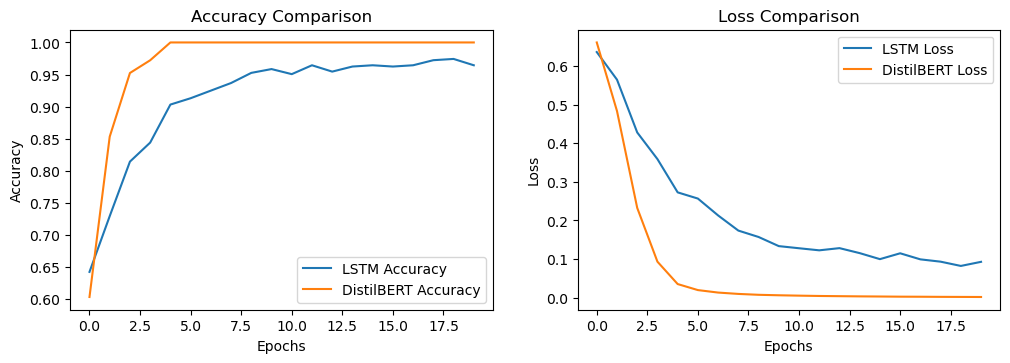

In [46]:
plt.figure(figsize=(12, 8))
# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Accuracy')
plt.plot(distilbert_history.history['accuracy'], label='DistilBERT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Loss')
plt.plot(distilbert_history.history['loss'], label='DistilBERT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.show()

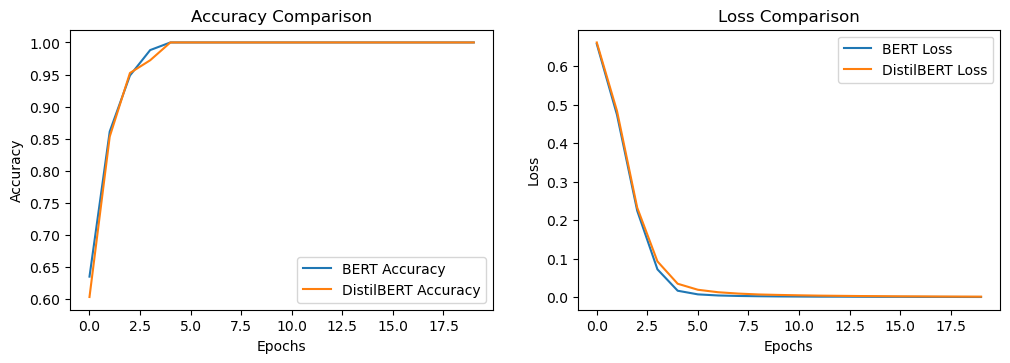

In [47]:
plt.figure(figsize=(12, 8))
# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(bert_history.history['accuracy'], label='BERT Accuracy')
plt.plot(distilbert_history.history['accuracy'], label='DistilBERT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(bert_history.history['loss'], label='BERT Loss')
plt.plot(distilbert_history.history['loss'], label='DistilBERT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.show()

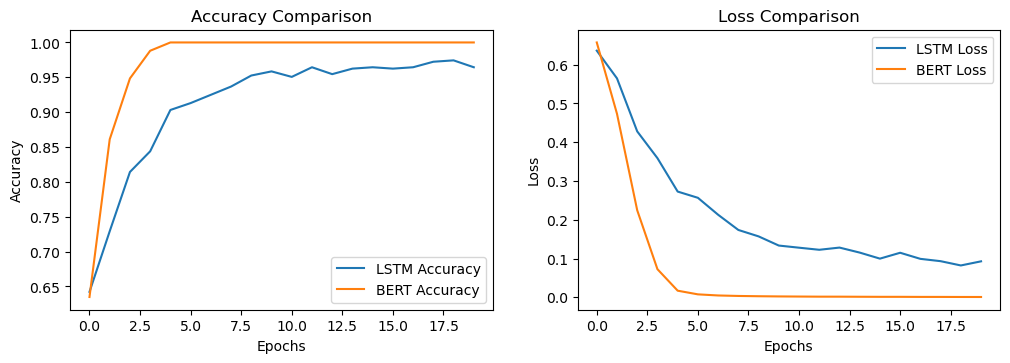

In [48]:
plt.figure(figsize=(12, 8))
# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Accuracy')
plt.plot(bert_history.history['accuracy'], label='BERT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Loss')
plt.plot(bert_history.history['loss'], label='BERT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.show()

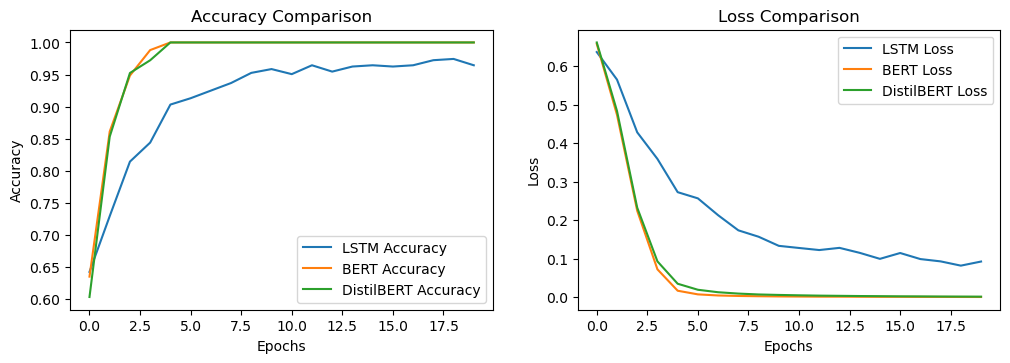

In [49]:
plt.figure(figsize=(12, 8))
# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(lstm_history.history['accuracy'], label='LSTM Accuracy')
plt.plot(bert_history.history['accuracy'], label='BERT Accuracy')
plt.plot(distilbert_history.history['accuracy'], label='DistilBERT Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison')
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(lstm_history.history['loss'], label='LSTM Loss')
plt.plot(bert_history.history['loss'], label='BERT Loss')
plt.plot(distilbert_history.history['loss'], label='DistilBERT Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison')
plt.legend()

plt.show()

In [50]:
#text summarization with ratings

In [51]:
#using lstm
def get(a):
    twt = [a]
    twt = tokenizer.texts_to_sequences(twt)
    twt = pad_sequences(twt, maxlen=28, dtype='int32', value=0)
    sentiment = lstm_model.predict(twt, batch_size=1, verbose=0)[0]
    return sentiment

In [52]:
test['Expected'] = test['Sanitation experience'].map(get)
test['positives'] = list(x[1] for x in test['Expected'])
Employment=test['Employment'].value_counts()
Employment= list(Employment.index)
groups = test.groupby(['Employment'])
val = groups.get_group(Employment[0])
negComments = list(val['Sanitation experience'][x] for x in val.index if np.argmax(val['Expected'][x]) == 0)



EmploymentDict = {}
for role in Employment:
    val = groups.get_group(role)
    totalPositives = list(val['positives'][x] for x in val.index)
    negComments = list(val['Sanitation experience'][x] for x in val.index if np.argmax(val['Expected'][x]) == 0)
    score = sum(totalPositives)/len(totalPositives)
    EmploymentDict[role] =  (round(score*10),negComments)


soln = pd.DataFrame()
soln['Employment'] = Employment
soln['Rating'] = list(EmploymentDict[x][0] for x in Employment)
soln['Negative Feedback'] = list(EmploymentDict[x][1] for x in Employment)


pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
soln.shape


(3, 3)

In [53]:
def sentenceCase(sentences):
    words=sentences.split(". ")
    new=".".join([word.capitalize() for word in words])
    return new

In [54]:
my_tool = language_tool_python.LanguageTool('en-US')  

def clean_string(text, stem="None"):

    final_string = ""

    # Remove line breaks
    text = re.sub(r'\n', '', text)

    # Remove puncuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.strip()
    return text

In [55]:
text = soln['Negative Feedback'][1]

In [56]:
# input list of strings , output text
def getText(a):
  text = ""
  for word in a:
    text += my_tool.correct(clean_string(word).capitalize())
    if(text[-1]==' '):
      text = text[:-1]
    text += ". "
  return text

In [57]:
Soln = soln.drop(['Negative Feedback'],axis = 1)

In [58]:
from transformers import pipeline
summarizer = pipeline("summarization")

No model was supplied, defaulted to sshleifer/distilbart-cnn-12-6 and revision a4f8f3e (https://huggingface.co/sshleifer/distilbart-cnn-12-6).
Using a pipeline without specifying a model name and revision in production is not recommended.
C:\Users\Sharmi\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [59]:
Summary2 = []
for x in soln['Negative Feedback']:
    if x == []:
        Summary2.append("-")
        continue
    # text = x
    preprocess_text = getText(x)
    # preprocess_text = ". ".join([(str(item)) if str(item)[-1] != '.' else (str(item))[:-1] for item in text])
    if len(preprocess_text.split()) >= 30:
        summarized = summarizer(preprocess_text, min_length=10, max_length=30)
        Summary2.append(summarized[0]['summary_text'])
    else:
        Summary2.append(preprocess_text)

In [60]:
Soln['Summary from BART Model'] = Summary2

In [61]:
Soln

,Employment,Rating,Summary from BART Model
0,Student,6,The restroom is very far from my class it is often crowded and it smells terrible . There is no proper facilities to dispose used pads .
1,Full Time,4,In my office the restrooms are not being cleaned regularly which has led to an unpleasant and unhygienic environment . No separate restrooms
2,Un-employed,3,People using the restroom should keep it clean as it is our responsibility . I hate the idea of western toilets and moreover during work hours sometime


In [62]:
#using DistilBERT
# Function to calculate sentiment
def get(text):
    inputs = distilbert_tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = distilbert_model(inputs["input_ids"])
    scores = tf.nn.softmax(outputs.logits).numpy()[0]  # Convert to probabilities
    return scores  # Returns [neg, neu, pos] probabilities

In [63]:

# Apply DistilBERT sentiment prediction
test['Expected'] = test['Sanitation experience'].map(get)

# Determine correct indexing based on score length
first_sample = test['Expected'].iloc[0]  # Check first sample

if len(first_sample) == 3:
    test['positives'] = [x[2] for x in test['Expected']]  # Positive sentiment
elif len(first_sample) == 2:
    test['positives'] = [x[1] for x in test['Expected']]  # Use second value
else:
    raise ValueError("Unexpected number of sentiment values!")

In [64]:
# Group by Employment
Employment = test['Employment'].value_counts().index.tolist()
groups = test.groupby(['Employment'])

EmpDict = {}
for role in Employment:
    val = groups.get_group(role)
    
    totalPositives = [val['positives'][x] for x in val.index]
    negComments = [val['Sanitation experience'][x] for x in val.index if np.argmax(val['Expected'][x]) == 0]  # Negative sentiment

    # Calculate rating
    if len(totalPositives) > 0:
        score = sum(totalPositives) / len(totalPositives)
    else:
        score = 0  # Handle division by zero

    EmpDict[role] = (round(score * 10), negComments)

In [65]:
# Create DataFrame for results
soln = pd.DataFrame()
soln['Employment'] = Employment
soln['Rating'] = [EmpDict[x][0] for x in Employment]
soln['Negative Feedback'] = [EmpDict[x][1] for x in Employment]
# Display DataFrame
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
soln

,Employment,Rating,Negative Feedback
0,Student,6,"[The restroom is very far from my class, it is often crowded, and it smells really bad., Girls don't have the basic knowledge in the disposal of used napkins. Therefore the college NSS Club should conduct an awareness program on how to dispose a used napkin, Bad, Dissatisfied with the odor of the restrooms , There is no proper facilities to dispose used pads, Keep your campus clean , Less cleanliness, Less number of restrooms with bad odor makes it irritating to use them, It's sometime very difficult to use the restroom but for urgent I use it but I don't like it, Hand wash and other toiletries must be provided. Very less number of restrooms., The smell OMG can't explain it such a bad one., No of restrooms should be increased and hand wash stations should be made available, It's not clean ,smells awful, used pads are everywhere,unsanitary,no buckets and cups ,, Some of them aren't keeping the rest rooms clean, Had worst experience by standing in a queue to access restrooms, In study place the people did not wrap their sanitary pads. They freely put down in dustbin or above the dustbin. It gives very nasty smell in the restroom. So Please avoid that. , There is a very bad smell in our study place toilet..Not properly disposed napkins are just disgusting..The mugs and buckets there are damaged (cant even hold water)..Once in a while,I use toilet because of these drawbacks., Feeling annoyed about the inadequate restrooms and cleanliness , Keep Indian restroom to avoid problems in hygiene.., Sometimes while using Western closet ,it will not be clean and correctly flushed. Sometimes the restrooms are dumped with period pads ., Using a western rest room at work place is little inconvenient due to cleanliness., Usage of restrooms in study place is restricted during periods, It is clean and neat but sometimes it is smelly, I feel there should be more western toilets ]"
1,Full Time,4,"[No separate rest rooms for women , Whenever I am using the toilet, I have to clean it by blowing good water., In my Office, the restrooms are not being cleaned regularly, which has led to an unpleasant and unhygienic environment. Additionally, there is no dustbin available, making it difficult to dispose ofwaste properly.Due to these issues, I often avoid using the office restrooms, which is becoming increasingly inconvenient. ]"
2,Un-employed,3,"[People using the restroom should keep it clean as it is our responsibility, I hate the idea of western toilets. And moreover during work hours sometime the used pads are not disposed properly and odor get into the whole restroom which makes it difficult and disgusting to use restrooms in hostel/ work place. But when it comes to home, each and everyone there is self conscious about others using it and proper cleaning of toilets is done including the usage of restroom freshners or liquids.]"


In [66]:
# using BERT
#Function to calculate sentiment
def get(text):
    inputs = bert_tokenizer(text, return_tensors="tf", truncation=True, padding=True)
    outputs = bert_model(inputs["input_ids"])
    scores = tf.nn.softmax(outputs.logits).numpy()[0]  # Convert to probabilities
    return scores  # Returns [neg, neu, pos] probabilities

In [67]:

# Apply BERT sentiment prediction
test['Expected'] = test['Sanitation experience'].map(get)

# Determine correct indexing based on score length
first_sample = test['Expected'].iloc[0]  # Check first sample

if len(first_sample) == 3:
    test['positives'] = [x[2] for x in test['Expected']]  # Positive sentiment
elif len(first_sample) == 2:
    test['positives'] = [x[1] for x in test['Expected']]  # Use second value
else:
    raise ValueError("Unexpected number of sentiment values!")

In [68]:
# Group by Employment
Employment = test['Employment'].value_counts().index.tolist()
groups = test.groupby(['Employment'])

EmpDict = {}
for role in Employment:
    val = groups.get_group(role)
    
    totalPositives = [val['positives'][x] for x in val.index]
    negComments = [val['Sanitation experience'][x] for x in val.index if np.argmax(val['Expected'][x]) == 0]  # Negative sentiment

    # Calculate rating
    if len(totalPositives) > 0:
        score = sum(totalPositives) / len(totalPositives)
    else:
        score = 0  # Handle division by zero

    EmpDict[role] = (round(score * 10), negComments)

In [69]:
# Create DataFrame for results
soln = pd.DataFrame()
soln['Employment'] = Employment
soln['Rating'] = [EmpDict[x][0] for x in Employment]
soln['Negative Feedback'] = [EmpDict[x][1] for x in Employment]
# Display DataFrame
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
soln

,Employment,Rating,Negative Feedback
0,Student,6,"[The restroom is very far from my class, it is often crowded, and it smells really bad., Girls don't have the basic knowledge in the disposal of used napkins. Therefore the college NSS Club should conduct an awareness program on how to dispose a used napkin, Bad, Dissatisfied with the odor of the restrooms , There is no proper facilities to dispose used pads, Keep your campus clean , Less cleanliness, Less number of restrooms with bad odor makes it irritating to use them, It's sometime very difficult to use the restroom but for urgent I use it but I don't like it, Hand wash and other toiletries must be provided. Very less number of restrooms., The smell OMG can't explain it such a bad one., No of restrooms should be increased and hand wash stations should be made available, It's not clean ,smells awful, used pads are everywhere,unsanitary,no buckets and cups ,, Some of them aren't keeping the rest rooms clean, Had worst experience by standing in a queue to access restrooms, In study place the people did not wrap their sanitary pads. They freely put down in dustbin or above the dustbin. It gives very nasty smell in the restroom. So Please avoid that. , There is a very bad smell in our study place toilet..Not properly disposed napkins are just disgusting..The mugs and buckets there are damaged (cant even hold water)..Once in a while,I use toilet because of these drawbacks., Feeling annoyed about the inadequate restrooms and cleanliness , Keep Indian restroom to avoid problems in hygiene.., Sometimes while using Western closet ,it will not be clean and correctly flushed. Sometimes the restrooms are dumped with period pads ., Using a western rest room at work place is little inconvenient due to cleanliness., Usage of restrooms in study place is restricted during periods, It is clean and neat but sometimes it is smelly, I feel there should be more western toilets ]"
1,Full Time,2,"[No separate rest rooms for women , Whenever I am using the toilet, I have to clean it by blowing good water., Sanitation maintenance is fine . But users should follow etiquette to keep it usable for others . , In my Office, the restrooms are not being cleaned regularly, which has led to an unpleasant and unhygienic environment. Additionally, there is no dustbin available, making it difficult to dispose ofwaste properly.Due to these issues, I often avoid using the office restrooms, which is becoming increasingly inconvenient. ]"
2,Un-employed,3,"[People using the restroom should keep it clean as it is our responsibility, I hate the idea of western toilets. And moreover during work hours sometime the used pads are not disposed properly and odor get into the whole restroom which makes it difficult and disgusting to use restrooms in hostel/ work place. But when it comes to home, each and everyone there is self conscious about others using it and proper cleaning of toilets is done including the usage of restroom freshners or liquids.]"
